In [9]:
import os
import io
import sys
import torch
import random
from PIL import Image
from pathlib import Path
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import save_image
from crp.image import imgify,vis_opaque_img,vis_img_heatmap,plot_grid

In [2]:
notebook_directory = Path().resolve().parent
sys.path.insert(0,str(notebook_directory.parent))
from sentinelmodels.pretrained_models import buildmodel
from sentinelmodels.preprocessing import SentinelDataset
from interpret.concept.conceptrelevance import ConceptRelevance

In [3]:
config={    
                "root_dir":r'D:/master-thesis/Dataset/anthroprotect',
                "datasplitfilename": r"infos.csv",
                "n_classes":2,
                "datasaved":True,
                "device":"cpu",
                "datasettype":"test",
                "models":["alexnet","vgg16","resnet18"],
                "modelweightpaths":[r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/alexnet_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/vgg16_best_model.pth",
                                    r"D:/Thesis/ExplainingWilderness/experiments/figures/trained_models/pretrained/resnet18_best_model.pth",
                                    ],
                "filterclass":[1],
                "cmap":"hot",
                "symmetric":False,
                "level":1
                }
csvfilepath=os.path.join(config["root_dir"],config["datasplitfilename"])
dataset = SentinelDataset(csvfilepath, config["root_dir"],output_channels=config["n_classes"],datasettype=config["datasettype"],filter_label=config["filterclass"],device=config["device"])
data_loader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
modelindex=-1
model=buildmodel(model_type=config["models"][modelindex],multiclass_channels=config["n_classes"],modelweightpath=config["modelweightpaths"][modelindex]).to(config["device"])
Concepts=ConceptRelevance(model,device=config["device"])
del model

In [13]:
preprocessing=None
filesavepath=r"D:/finaldraft/ExplainingWilderness/experiment/Notebooks/referenceimages/ResNetWildernessConcepts"
build=False
batch_size=8
ckpoint=10

In [14]:
Concepts.build_reference_images(dataset, preprocessing, filesavepath, compositename="epsilonplusflat", canonizerstype=config["models"][modelindex], device=config["device"], imagecache=True, imagecachefilepath="cache", max_target="max", build=build, batch_size=batch_size, chkpoint=ckpoint)

In [15]:
recordlayers=list(Concepts.layer_map.keys())
layer_name=recordlayers[-5]

In [32]:
channelindex=[0,15,30,45,60,75]
plt_fun=vis_opaque_img

In [33]:
ref=Concepts.layer_reference_image(layer_name, dataset, preprocessing, filesavepath,channelindex, compositename="epsilonplus", canonizerstype=config["models"][modelindex], device=config["device"], imagecache=False, relevance_range=(0, 8), imagemode="relevance",max_target="max", plotfn=plt_fun, receptivefield=False,build=False, batch=8, chkpoint=50)

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\crp\image.py:288: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


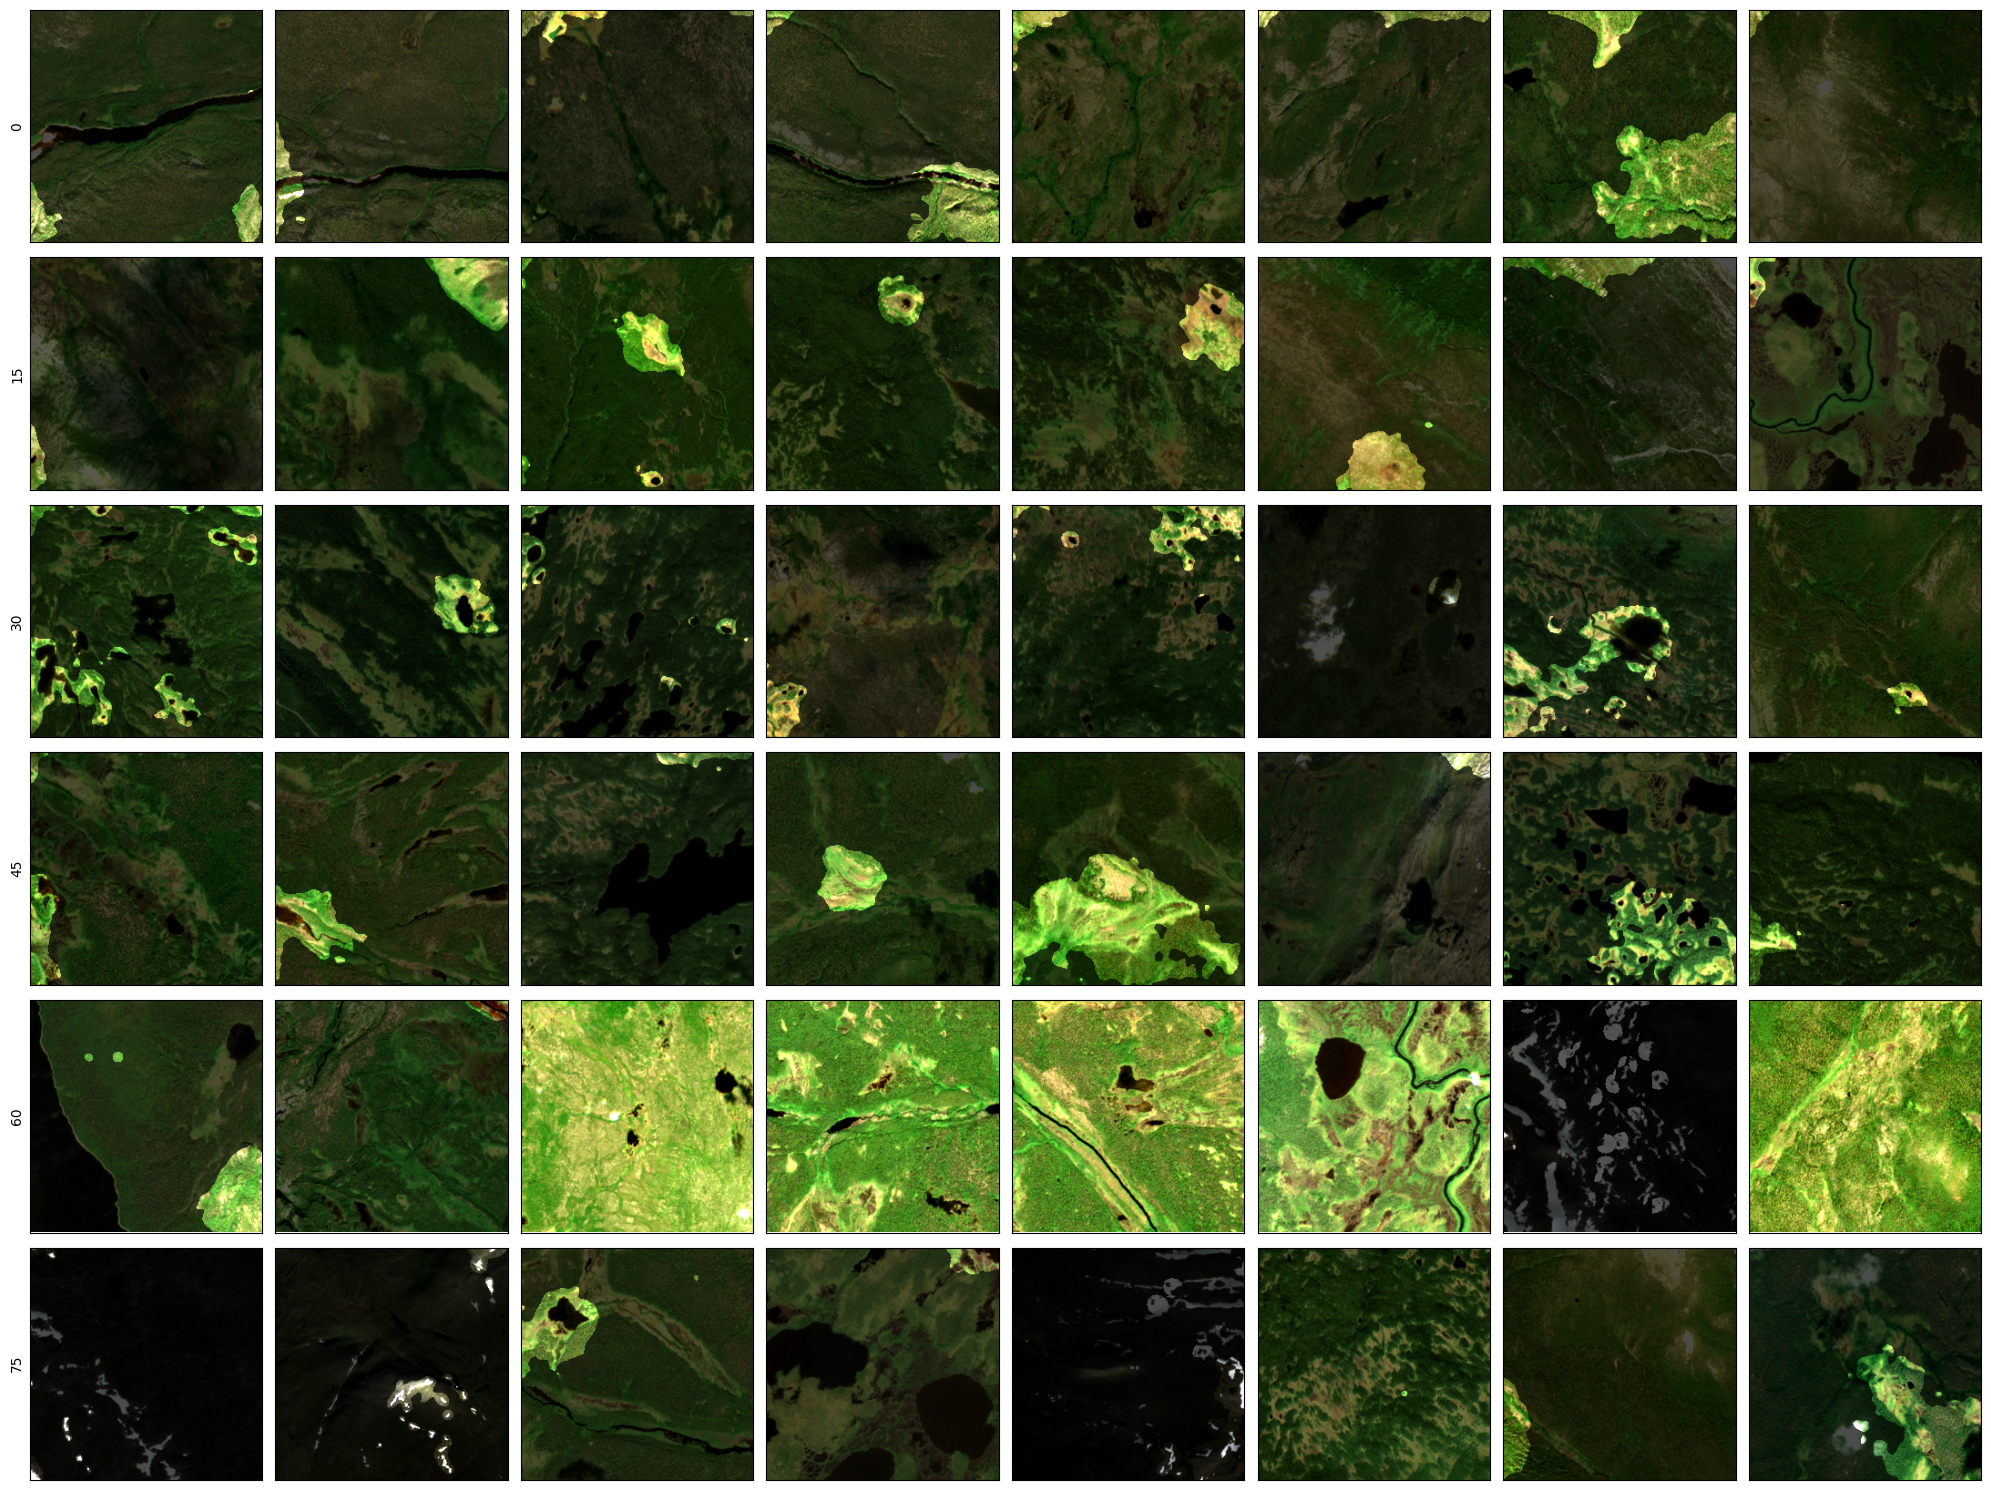

In [41]:
if plt_fun==vis_opaque_img:
    plot_grid(ref,cmap="france",padding=False,figsize=(20,15))

In [25]:
finaldict={}
for channelindex,value in ref.items():
    imagesmaks=vis_opaque_img(value[0],value[1],alpha=0.3,kernel_size=27)
    value[1][value[1]<0]=0
    heatmaps=imgify(value[1],cmap="hot",symmetric=False,level=1,grid=(1,8),padding=False)
    total_width = sum(img.width for img in imagesmaks)
    max_height = max(img.height for img in imagesmaks)

    # Create a new blank image with the calculated dimensions
    combined_image = Image.new('RGB', (total_width, max_height))

    # Paste each image into the combined image
    x_offset = 0
    for img in imagesmaks:
        combined_image.paste(img, (x_offset, 0))
        x_offset += img.width
    width1, height1 = heatmaps.size
    width2, height2 = combined_image.size

    # Ensure both images have the same height
    if width1 != width2:
        raise ValueError("Image heights must be the same")

    # Calculate the total width for the concatenated image
    total_width = width1 
    max_height = height1 + height2# Since the heights are the same

    # Create a new blank image with the calculated dimensions
    final_image = Image.new('RGB', (total_width, max_height))

    # Paste the first image at the left
    final_image.paste(heatmaps, (0, 0))

    # Paste the second image to the right of the first image
    final_image.paste(combined_image, (0,height1 ))
    finaldict[channelindex]=final_image

d:\finaldraft\ExplainingWilderness\thesis\Lib\site-packages\zennit\image.py:187: RuntimeWarning: invalid value encountered in divide
  array = (array - vmin) / (vmax - vmin)


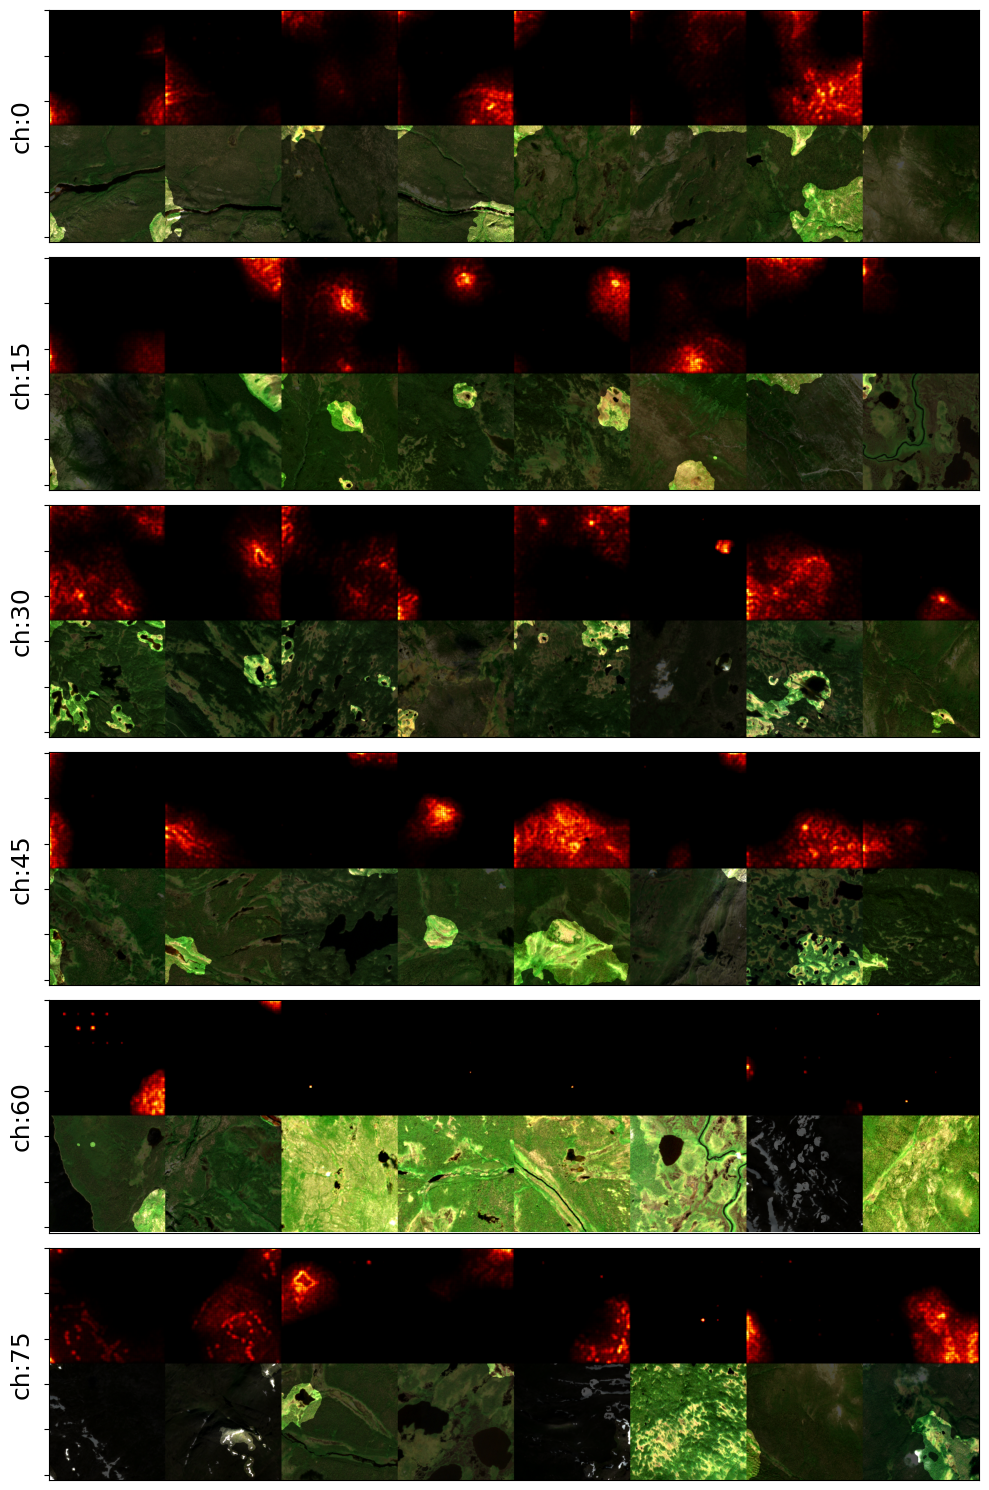

In [42]:
fig, axs = plt.subplots(len(finaldict.keys()),1, figsize=(25, 15))  # Adjust the figsize as needed

# Loop through the images and labels, and plot them as rows
for i,(keys,image) in enumerate(finaldict.items()):
    axs[i].imshow(image)
    axs[i].get_xaxis().set_visible(False)
    axs[i].get_yaxis().set_visible(True)
    axs[i].set_ylabel("ch:"+str(keys), fontsize=18, rotation='vertical')
    #axs[i].get_yaxis().set_visible(True)
    axs[i].set_yticklabels([])
    #axs[i].axis('off')

# Adjust spacing between subplots
plt.tight_layout()
saved_path="D:/finaldraft/ExplainingWilderness/experiment/Notebooks/temp/concepts"
plt.savefig(os.path.join(saved_path,"./"+config["models"][modelindex]+"_"+layer_name+"_global_concepts_heatmaps_masks.png"),dpi=600)
# Show the plot
plt.show()